<img src="images/ublogo.png"/>

### CSE610 - Bayesian Non-parametric Machine Learning

  - Lecture Notes
  - Instructor - Varun Chandola
  - Term - Fall 2020

### Objective
The objective of this notebook is to discuss the relationship between Gaussian process based methods, discussed in the class so far, and deep-learning. In particular, we will talk about: a). the relationship between the two, b). how to combine GPs with neural networks, and c). how to make GPs behave like deep neural networks, i.e., deep Gaussian Processes.

<div class="alert alert-info">

**Note:** This material is based on a collection of recent papers on this topic, including [Deep neural networks as Gaussian Processes](https://arxiv.org/pdf/1711.00165.pdf), and [Deep Gaussian Processes](http://proceedings.mlr.press/v31/damianou13a.pdf).

</div>

### Equivalence between GP and Neural Networks

> This was established way back in 1994 by Radford Neal in this PhD thesis - *Bayesian Learning for Neural Networks*

Consider a multi-layered perceptron. For any hidden layer (indexed by $l$), we will use the following notation:
- $N_l$ - width of the layer $l$ or the number of nodes
- ${\bf x}^l$ - input to the $l^{th}$ layer (length will be $N_{l-1}$)
- ${\bf z}^l$ - output (before non-linear transformation) of the $l^{th}$ layer (length will be $N_l$) 
- ${\bf b}^l$ - bias vector for the $l^{th}$ layer (length will be $N_l$)
- $\phi(\cdot)$ - non-linear activation function
- $i$ - index of the $i^{th}$ node in the hidden layer
- $W^l$ - weight matrix at the $l^{th}$ hidden layer
  * $W^{l}_{ij}$ - The $j^{th}$ component of the weight vector for the $i^{th}$ unit in the $l^{th}$ layer

Thus, ${\bf x}^0$ will correspond to the input (${\bf x}$) to the neural network, while $\phi({\bf z}^L)$ will be the output of the neural network, where $L$ is the index of the final layer.

Consider a single-hidden layer neural network. The input to the final layer will be, ${\bf x}^1$, whose $j^{th}$ component will be:
$$
x_j^1({\bf x}) = \phi(b_j^0 + \sum_{k=1}^d W^0_{jk}x_k)
$$
Notice that we are using $x_k$ (the $k^{th}$ entry in the input vector ${\bf x}$), instead of the general term $x^0_k$.

The output of the final layer will be:
$$
z_i^1({\bf x}) = b_i^1 + \sum_{j=1}^{N_0} W^1_{ij}x^1_j
$$

Also note that we are writing these terms as a function of the input $({\bf x})$, since their values depend on the input to the neural network.

We assume that the weight and bias parameters for layer $l$ are independent and randomly drawn from a Gaussian with zero mean and variance as $\sigma^2_w/N_l$ and $\sigma^2_b$, respectively.

> **Observation 1**: The post-activations, $x^1_j({\bf x})$ and $x^1_{j'}({\bf x})$ are independent of each other. This is true because the weight and bias parameters are assumed to be i.i.d.

> **Observation 2**: $z^1_i({\bf x})$ will be Gaussian distributed. This is true because $z^1_i({\bf x})$ is a sum of i.i.d. terms. And, the **Central Limit Theorem** dictates that in the limit of infinite width, i.e., $N_1 \rightarrow \infty$, the sum will be a random variable with a Gaussian distribution.

Consider the values of $z^1_i$ for several inputs, $\{{\bf x}_1, {\bf x}_2,\ldots,{\bf x}_k\}$.
> **Observation 3**: The finite collection, $\{z^1_i({\bf x}_1), z^1_i({\bf x}_2),\ldots,z^1_i({\bf x}_k\})$, will have a joint multivariate Gaussian distribution.

If we consider $z^1_i(\cdot)$ as a function of ${\bf x}$, then the above observation is equivalent to a Gaussian process.

> **Observation 4**: $z^1_i({\bf x}) \sim \mathcal{GP}(\mu^1({\bf x}),k^1({\bf x},{\bf x}'))$

Note that the GP prior is independent of $i$.

Since the parameters have zero mean, the mean function will also be 0, i.e.,
$$
\mu^1({\bf x}) \equiv \mathbb{E}[z_i^1({\bf x})] = 0
$$
The covariance function can also be derived from the above expressions as:
$$
k^1({\bf x},{\bf x}') \equiv \mathbb{E}[z_i^1({\bf x})z_i^1({\bf x}')] = \sigma^2_b + \sigma^2_w\mathbb{E}[x_i^1({\bf x})x_i^1({\bf x}')] \equiv \sigma^2_b + \sigma^2_wC({\bf x},{\bf x}')
$$
where $C(\cdot,\cdot)$ can be analytically computed for a given activation function $\phi(\cdot)$. 

For example, as discussed in Chapter 4 of the GPML book, if $\phi(\cdot)$ is the `erf` function, i.e.,
$$
\phi(y) = erf(y) = \frac{2}{\pi}\int_0^y e^{-t^2}dt
$$
then the corresponding $C$ function is obtained as:
$$
C({\bf x},{\bf x}') = \frac{2}{\pi}\sin^{-1}\left(\frac{2\tilde{{\bf x}}^\top\Sigma \tilde{{\bf x}}'}{\sqrt{(1+2\tilde{{\bf x}}^\top\Sigma \tilde{{\bf x}})(1+2\tilde{{\bf x}}'^\top\Sigma \tilde{{\bf x}}')}}\right)
$$
where $\tilde{\bf x}'$ is the augmented input vector (including a 1 for the bias term) and $\Sigma$ is a diagonal matrix consisting of $\sigma^2_b$ and $\sigma^2_w$ on the diagonal terms.

<div class="alert alert-warning">
Above discussion shows that an infinite width single-hidden layer neural network is equivalent to a GP with a specific covariance function, which depends on the activation function used in the neural network.
</div>

This can be extended to deeper layers by induction. Thus, if the neural network has several hidden layers with infinite width, the output at each hidden layer is equivalent to a GP, where the covariance function at a given hidden layer recursively depends on the covariance function at the previous hidden layer.

$$
k^l({\bf x},{\bf x}') = \sigma^2_b + \sigma^2_wF_{\phi}(k^{l-1}({\bf x},{\bf x}'),k^{l-1}({\bf x},{\bf x}),k^{l-1}({\bf x}',{\bf x}'))
$$
where $F_{\phi}$ is a determinstic function whose form depends on the activation function $\phi$.

### What does this get us?

With the above equivalence, we can now construct a GP model, and use it as a infinite width neural network.

<img src='images/gpnn.png'/>

A [recent study](https://arxiv.org/pdf/1808.05587.pdf) extends the above idea to *convolution neural networks*. We will not discuss it here.

### Deep Gaussian Processes

Making GPs deeper (similar to a deep neural network) to make them more powerful.

Consider the following deep neural network:

<img src="images/deepnn.png" width="400" height="600"/>

Each layer of the neural network is able to perform a certain interaction of the inputs (from the previous layer) and pass it on.
\begin{eqnarray}
{\bf h}_1 & = & \phi({\bf W}_1{\bf x})\\
{\bf h}_2 & = & \phi({\bf W}_2{\bf h}_1)\\
{\bf h}_3 & = & \phi({\bf W}_3{\bf h}_2)\\
y & = & {\bf w}_4^\top{\bf h}_3\\
\end{eqnarray}

Of course, we can keep increasing the number of layers, or adding more nodes (units) in each layer to make the model more *expressive*. However, this could very easily lead to *overfitting issues*.

There are ways to handle this, including regularization, dropout, or even reparameterize each ${\bf W}$ with a low-rank approximation, e.g., **singular value decomposition**:
$$
{\bf W} = {\bf U}\boldsymbol{\Lambda}{\bf V}^\top
$$

The above solution (of using SVD) would give us an alternate neural network architecture with *bottleneck" layers:
<img src="images/deepnn_bottleneck.png" width="700" height="800"/>

which can be mathematically written as:

\begin{eqnarray}
{\bf z}_1 & = & {\bf V}_1^\top{\bf x}\\
{\bf h}_1 & = & \phi({\bf U}_1{\bf z}_1)\\
{\bf z}_2 & = & {\bf V}_2^\top{\bf h}_1\\
{\bf h}_2 & = & \phi({\bf U}_2{\bf z}_2)\\
{\bf z}_3 & = & {\bf V}_3^\top{\bf h}_2\\
{\bf h}_3 & = & \phi({\bf U}_3{\bf z}_3)\\
y & = & {\bf w}_4^\top{\bf h}_3\\
\end{eqnarray}

or, more concisely:
\begin{eqnarray}
{\bf z}_1 & = & {\bf V}_1^\top{\bf x}\\
{\bf z}_2 & = & {\bf V}_2^\top\phi({\bf U}_1{\bf z}_1)\\
{\bf z}_3 & = & {\bf V}_3^\top\phi({\bf U}_2{\bf z}_2)\\
y & = & {\bf w}_4^\top{\bf h}_3\\
\end{eqnarray}

#### Introducing a cascade of Gaussian Processes
What if we replace each of these neural networks with a Gaussian process? Remember that a Gaussian process layer would be equivalent to using a neural network layer with infinite width.
\begin{eqnarray}
{\bf z}_1 & = & f_1({\bf x})\\
{\bf z}_2 & = & f_2({\bf z}_1)\\
{\bf z}_3 & = & f_3({\bf z}_2)\\
y & = & f_4({\bf z}_3)
\end{eqnarray}

You can thinking of a deep GP as a composite *multivariate* function:
$$
g({\bf x}) = f_5(f_4(f_3(f_2(f_1({\bf x})))))
$$
or from a probabilistic perspective:
$$
p(y\vert {\bf x}) = p(y\vert {\bf f}_5)p({\bf f}_5 \vert {\bf f}_4)p({\bf f}_4 \vert {\bf f}_3)p({\bf f}_3 \vert {\bf f}_2)p({\bf f}_2 \vert {\bf f}_1)p({\bf f}_1 \vert {\bf x})
$$

Here I am using ${\bf f}_i$ to denote the output of the $i^{th}$ function, $f_i()$.

<img src="images/deepgp_graphical.png"/>

### Why deep GPs?

If the output of composing many functions is another function, why bother with stacking them up, why not direcly model the final function.

The reason is that we can use different types of covariance functions in each layer and make the model more expressive.

Another advantage is that we can add other dependencies in the above chain. For instance we can have output nodes emerging at any depth of the chain.

<img src="images/deepgp_graphical2.png"/>

### So what's the issue?

The above description of deep GP seems straightforward. You introduce a sequence of GP functions, each applied to the previous function. However, this introduces a lot of challenges for inference and training. The main reason is that the output distribution (due to several layers of non-linear transformations) will no longer be Gaussian.

<img src="images/nonlinear_transformation.png"/>

Standard approaches for inference and Bayesian training of the hyper-parameters will fail here. The paper on [Deep Gaussian Processes](http://proceedings.mlr.press/v31/damianou13a.pdf) proposes an alternate variational inference approach (will not be discussed here).

In [6]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/XhIvygQYFFQ?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')


### Deep GP using `GPy`

You will need to install `PyDeepGP` for this demonstration:
```shell
pip install git+https://github.com/SheffieldML/PyDeepGP.git
```

#### Data - Olympic Marathon Data
The data consists of the pace of Olympic Gold Medal Marathon winners for the Olympics from 1896 to present. First we load in the data and plot.

In [20]:
%run Utilities.ipynb
import teaching_plots as plot
import mlai

In [26]:
data = pods.datasets.olympic_marathon_men()
x = data['X']
y = data['Y']

offset = y.mean()
scale = np.sqrt(y.var())

yhat = (y-offset)/scale

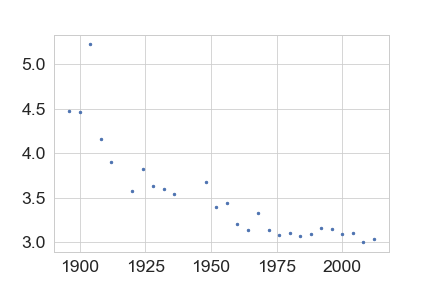

In [24]:
plt.plot(x,y,'.')

In [39]:
m_full = GPy.models.GPRegression(x,yhat)
_ = m_full.optimize() # Optimize parameters of covariance function

In [40]:
xt = np.linspace(1870,2030,200)[:,np.newaxis]
yt_mean, yt_var = m_full.predict(xt)
yt_sd=np.sqrt(yt_var)

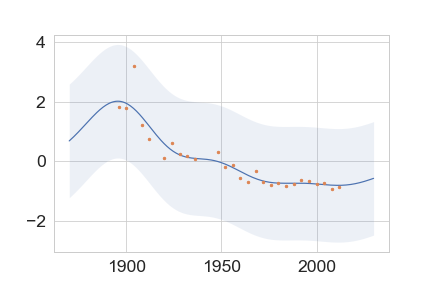

In [41]:
plot_gp(yt_mean,yt_sd, xt,legend=False)
plt.plot(x,yhat,'.')

We can remove an outlier that might be causing the model fits to be erratic.

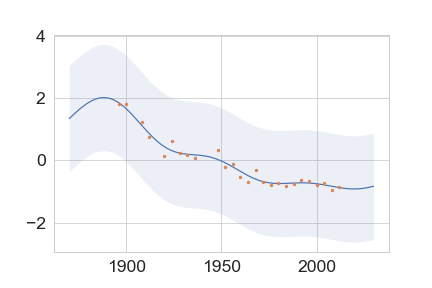

In [55]:
x_clean=np.vstack((x[0:2, :], x[3:, :]))
y_clean=np.vstack((y[0:2, :], y[3:, :]))
y_clean_hat = (y_clean-offset)/scale

m_clean = GPy.models.GPRegression(x_clean,y_clean_hat)
_ = m_clean.optimize()

xt = np.linspace(1870,2030,200)[:,np.newaxis]
yt_mean, yt_var = m_clean.predict(xt)
yt_sd=np.sqrt(yt_var)

plot_gp(yt_mean,yt_sd, xt,legend=False)
plt.plot(x_clean,y_clean_hat,'.')

#### Deep GP fit

In [43]:
import deepgp

In [45]:
hidden = 1
m = deepgp.DeepGP([y.shape[1],hidden,x.shape[1]],Y=yhat, X=x, inits=['PCA','PCA'], 
                  kernels=[GPy.kern.RBF(hidden,ARD=True),
                           GPy.kern.RBF(x.shape[1],ARD=True)], # the kernels for each layer
                  num_inducing=50, back_constraint=False)

In [49]:
# Call the initalization
#m.initialize()

In [47]:
for layer in m.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
m.optimize(messages=True,max_iters=10000)

In [50]:
#m.staged_optimize(messages=(True,True,True))


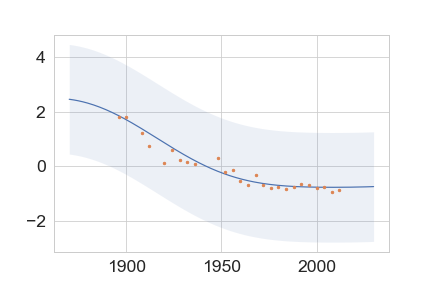

In [56]:
xt = np.linspace(1870,2030,200)[:,np.newaxis]
yt_mean, yt_var = m.predict(xt)
yt_sd=np.sqrt(yt_var)

plot_gp(yt_mean,yt_sd, xt,legend=False)
plt.plot(x_clean,y_clean_hat,'.')